In [39]:
pip install pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [41]:
from pykrx import stock
# 네이버 금융에서 카카오 주가를 가져오기
data = stock.get_market_ohlcv_by_date("20100101", "20230526", "035720") #2010.1.1 ~ 2023.05.26 까지 주가
print(data)

               시가     고가     저가     종가      거래량         거래대금   등락률
날짜                                                                
2010-01-04  70300  74200  69100  73400   158976  11508451400  4.41
2010-01-05  73000  75300  72200  74000   124156   9196806000  0.82
2010-01-06  74600  75200  73000  74300    72453   5383054600  0.41
2010-01-07  74300  74800  72100  73400    99241   7260270100 -1.21
2010-01-08  73500  73500  70100  72900   114818   8234546900 -0.68
...           ...    ...    ...    ...      ...          ...   ...
2023-05-22  57900  58100  57600  57900   985462  57068058200  0.00
2023-05-23  58100  58200  57600  58000  1015317  58763734800  0.17
2023-05-24  57500  57600  56700  56800  1258754  71754132400 -2.07
2023-05-25  56600  57000  56300  56700  1177829  66732998100 -0.18
2023-05-26  56400  57000  56400  56600   709988  40241580600 -0.18

[3308 rows x 7 columns]


In [42]:
# 필요 없는 column 삭제
X = data.drop(columns=["거래량","거래대금", "등락률"])
# Y 데이터로 종가 선택
Y = data.iloc[:, 3:4]

print(X)
print(Y)

               시가     고가     저가     종가
날짜                                    
2010-01-04  70300  74200  69100  73400
2010-01-05  73000  75300  72200  74000
2010-01-06  74600  75200  73000  74300
2010-01-07  74300  74800  72100  73400
2010-01-08  73500  73500  70100  72900
...           ...    ...    ...    ...
2023-05-22  57900  58100  57600  57900
2023-05-23  58100  58200  57600  58000
2023-05-24  57500  57600  56700  56800
2023-05-25  56600  57000  56300  56700
2023-05-26  56400  57000  56400  56600

[3308 rows x 4 columns]
               종가
날짜               
2010-01-04  73400
2010-01-05  74000
2010-01-06  74300
2010-01-07  73400
2010-01-08  72900
...           ...
2023-05-22  57900
2023-05-23  58000
2023-05-24  56800
2023-05-25  56700
2023-05-26  56600

[3308 rows x 1 columns]


In [53]:
X

,시가,고가,저가,종가
날짜,,,,
2010-01-04,70300,74200,69100,73400
2010-01-05,73000,75300,72200,74000
2010-01-06,74600,75200,73000,74300
2010-01-07,74300,74800,72100,73400
2010-01-08,73500,73500,70100,72900
...,...,...,...,...
2023-05-22,57900,58100,57600,57900
2023-05-23,58100,58200,57600,58000
2023-05-24,57500,57600,56700,56800


In [55]:
"""
학습이 잘되기 위해 데이터 정규화 
MinMaxScaler	최대/최소값이 각각 1, 0이 되도록 변경
StandardScaler	각 특징의 평균을 0, 분산을 1이 되도록 변경
"""

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
Y_mm = mm.fit_transform(Y) 
"""
학습 데이터는 3308개의 데이터 중에서 70%(2315개)를 사용
테스트 데이터는 나머지 30%를 사용
"""
X_train = X_ss[:2315, :]
X_test = X_ss[2315:, :]

Y_train = Y_mm[:2315, :]
Y_test = Y_mm[2315:, :] 

print("Training Shape", X_train.shape, Y_train.shape)
print("Testing Shape", X_test.shape, Y_test.shape) 

ValueError: ignored

In [44]:
"""
데이터를 Tensor로 바꾸고, Variable로 감싸줌
"""
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

Y_train_tensors = Variable(torch.Tensor(Y_train))
Y_test_tensors = Variable(torch.Tensor(Y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, Y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, Y_test_tensors.shape) 

Training Shape torch.Size([2315, 1, 4]) torch.Size([2315, 1])
Testing Shape torch.Size([993, 1, 4]) torch.Size([993, 1])


In [45]:
# GPU 사용 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(torch.cuda.get_device_name(0))

Tesla T4


In [46]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM, self).__init__()
    self.num_classes  = num_classes 
    self.num_layers   = num_layers 
    self.input_size   = input_size 
    self.hidden_size  = hidden_size 
    self.seq_length   = seq_length 
  
    # LSTM 모델 정의
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc   = nn.Linear(128, num_classes)

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태 초기화
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 초기 셀 초기화
    
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
   
    hn  = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out) # 선형 데이터를 비선형 데이터로 변경
    out = self.fc(out)
   
    return out 

In [47]:
num_epochs    = 30000
learning_rate = 0.00001

input_size  = 4 # 시가 고가 저가 종가 라서 4
hidden_size = 2
num_layers  = 1 

num_classes = 1


In [56]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()
optimizer     = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

lstm

LSTM(
  (lstm): LSTM(4, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [57]:
# 학습
for epoch in range(num_epochs):
  outputs = lstm.forward(X_train_tensors_final.to(device))
  optimizer.zero_grad()

  loss = loss_function(outputs, Y_train_tensors.to(device))

  loss.backward()
 
  optimizer.step()
  if epoch % 1000 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.33588
Epoch: 1000, loss: 0.11903
Epoch: 2000, loss: 0.04081
Epoch: 3000, loss: 0.02373
Epoch: 4000, loss: 0.02040
Epoch: 5000, loss: 0.01694
Epoch: 6000, loss: 0.01271
Epoch: 7000, loss: 0.00854
Epoch: 8000, loss: 0.00526
Epoch: 9000, loss: 0.00319
Epoch: 10000, loss: 0.00207
Epoch: 11000, loss: 0.00148
Epoch: 12000, loss: 0.00119
Epoch: 13000, loss: 0.00105
Epoch: 14000, loss: 0.00096
Epoch: 15000, loss: 0.00089
Epoch: 16000, loss: 0.00083
Epoch: 17000, loss: 0.00077
Epoch: 18000, loss: 0.00072
Epoch: 19000, loss: 0.00067
Epoch: 20000, loss: 0.00062
Epoch: 21000, loss: 0.00057
Epoch: 22000, loss: 0.00053
Epoch: 23000, loss: 0.00049
Epoch: 24000, loss: 0.00045
Epoch: 25000, loss: 0.00041
Epoch: 26000, loss: 0.00037
Epoch: 27000, loss: 0.00033
Epoch: 28000, loss: 0.00029
Epoch: 29000, loss: 0.00026


예측하기

In [50]:
df_X_ss = ss.transform(data.drop(columns=["거래량","거래대금", "등락률"]))
df_Y_mm = mm.transform(data.iloc[:, 3:4])

# 텐서로 변환
df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_Y_mm = Variable(torch.Tensor(df_Y_mm))

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

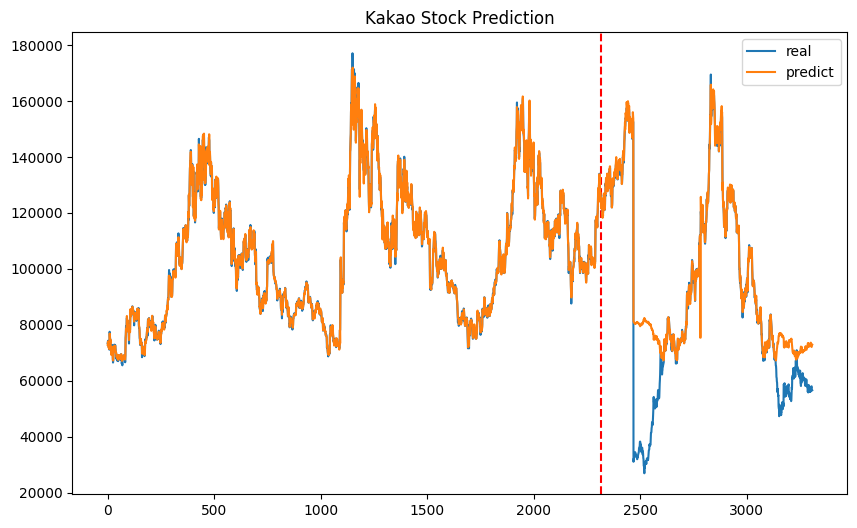

In [51]:
train_predict = lstm(df_X_ss.to(device))
data_predict  = train_predict.data.detach().cpu().numpy() # 예측값
dataY_plot    = df_Y_mm.data.numpy() # 실제값

print(dataY_plot)
print(data_predict)

data_predict  = mm.inverse_transform(data_predict)
dataY_plot    = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(10,6))
plt.axvline(x=2315, c='r', linestyle='--') # 2315 = 훈련 데이터의 수

plt.plot(dataY_plot, label='real')
plt.plot(data_predict, label='predict')
plt.title('Kakao Stock Prediction')
plt.legend()
plt.show()